# Experiments on the German Credit datasets
Old version: https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)
Corrected version: https://archive.ics.uci.edu/ml/datasets/South+German+Credit+%28UPDATE%29 / https://www.kaggle.com/c/south-german-credit-prediction/overview/data-overview

Some meanings of the discrete/ordinal feature values in the old version were wrong.
For example, for feature "checking status",

(inferred by the old dataset) a data object's value is                    '1' in the old dataset meaning negative DM.
(by new dataset) However, it should have been value          '4' in the old dataset meaning no checking account

(inferred by the old dataset) a data object's value is                    **'2' in the new dataset** *meaning negative DM*
(by new dataset) However, it should have been value          '1' in the old dataset meaning no checking account

Whether using the encoding scheme in the old or the new dataset, the feature value should be corrected according to the true meaning. The procedures in this experiment are:
1. Encode the dataset using the new dataset's meaning,
2. According to the *meanings of the old dataset*, **find encoded number in the new dataset and modify the feature values**.
3. Train first on the data points by *meanings of the old dataset* to get the base NN
4. gradually train on the data points by meanings of the new dataset to get the shifted NNs.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, make_scorer
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve

pd.options.display.max_columns = 100
pd.options.display.max_rows = 150

import warnings

warnings.filterwarnings('ignore')
from utilexp import *
from expnns.utilcredit import *
from expnns.preprocessor import Preprocessor

### Process the old version dataset

In [2]:
df_old, df_old_mm, df_old_enc, preprocessor_old = load_old("../datasets/credit/old/german.data")

In [3]:
df_old.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   checking-status  1000 non-null   int64
 1   duration         1000 non-null   int64
 2   credit-history   1000 non-null   int64
 3   purpose          1000 non-null   int64
 4   amount           1000 non-null   int64
 5   savings          1000 non-null   int64
 6   employment       1000 non-null   int64
 7   rate             1000 non-null   int64
 8   sex-status       1000 non-null   int64
 9   guarantors       1000 non-null   int64
 10  residence        1000 non-null   int64
 11  property         1000 non-null   int64
 12  age              1000 non-null   int64
 13  installment      1000 non-null   int64
 14  housing          1000 non-null   int64
 15  num-credits      1000 non-null   int64
 16  job              1000 non-null   int64
 17  liable           1000 non-null   int64
 18  phone    

In [4]:
df_old_enc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 73 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   checking-status_0  1000 non-null   float64
 1   checking-status_1  1000 non-null   float64
 2   checking-status_2  1000 non-null   float64
 3   checking-status_3  1000 non-null   float64
 4   duration           1000 non-null   float64
 5   credit-history_0   1000 non-null   float64
 6   credit-history_1   1000 non-null   float64
 7   credit-history_2   1000 non-null   float64
 8   credit-history_3   1000 non-null   float64
 9   credit-history_4   1000 non-null   float64
 10  purpose_0          1000 non-null   float64
 11  purpose_1          1000 non-null   float64
 12  purpose_2          1000 non-null   float64
 13  purpose_3          1000 non-null   float64
 14  purpose_4          1000 non-null   float64
 15  purpose_5          1000 non-null   float64
 16  purpose_6          1000 n

In [5]:
display(pd.DataFrame(data=df_old_mm.values[-1].reshape(1, -1), columns=columns))
display(preprocessor_old.encode_one(df_old_mm.values[-1]))

,checking-status,duration,credit-history,purpose,amount,savings,employment,rate,sex-status,guarantors,residence,property,age,installment,housing,num-credits,job,liable,phone,foreign,good-credit
0,2.0,0.602941,1.0,2.0,0.238032,2.0,0.0,2.0,1.0,0.0,3.0,1.0,0.142857,2.0,2.0,0.0,2.0,0.0,0.0,0.0,1.0


,checking-status_0,checking-status_1,checking-status_2,checking-status_3,duration,credit-history_0,credit-history_1,credit-history_2,credit-history_3,credit-history_4,purpose_0,purpose_1,purpose_2,purpose_3,purpose_4,purpose_5,purpose_6,purpose_7,purpose_8,purpose_9,purpose_10,amount,savings_0,savings_1,savings_2,savings_3,savings_4,employment_0,employment_1,employment_2,employment_3,employment_4,rate_0,rate_1,rate_2,rate_3,sex-status_0,sex-status_1,sex-status_2,sex-status_3,guarantors_0,guarantors_1,guarantors_2,residence_0,residence_1,residence_2,residence_3,property_0,property_1,property_2,property_3,age,installment_0,installment_1,installment_2,housing_0,housing_1,housing_2,num-credits_0,num-credits_1,num-credits_2,num-credits_3,job_0,job_1,job_2,job_3,liable_0,liable_1,phone_0,phone_1,foreign_0,foreign_1,good-credit
0,1.0,1.0,1.0,0.0,0.602941,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.238032,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.142857,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0


In [6]:
Xo, yo = df_old_enc.drop(columns=['good-credit']), pd.DataFrame(df_old_enc['good-credit'])
SPLIT = .2
Xo_train, Xo_test, yo_train, yo_test = train_test_split(Xo, yo, stratify=yo, test_size=SPLIT, shuffle=True,
                                                        random_state=0)
print(f'DATASET SIZE : train = {Xo_train.shape} {yo_train.shape} / test = {Xo_test.shape} {yo_test.shape}')


DATASET SIZE : train = (800, 72) (800, 1) / test = (200, 72) (200, 1)


### Process the new version dataset


In [7]:
df_new, df_new_mm, df_new_enc, preprocessor_new = load_new("../datasets/credit/new/train.csv")

In [8]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 1 to 800
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   checking-status  800 non-null    int32
 1   duration         800 non-null    int32
 2   credit-history   800 non-null    int32
 3   purpose          800 non-null    int32
 4   amount           800 non-null    int32
 5   savings          800 non-null    int32
 6   employment       800 non-null    int32
 7   rate             800 non-null    int32
 8   sex-status       800 non-null    int32
 9   guarantors       800 non-null    int32
 10  residence        800 non-null    int32
 11  property         800 non-null    int32
 12  age              800 non-null    int32
 13  installment      800 non-null    int32
 14  housing          800 non-null    int32
 15  num-credits      800 non-null    int32
 16  job              800 non-null    int32
 17  liable           800 non-null    int32
 18  phone     

In [9]:
df_new_enc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 799 entries, 1 to 799
Data columns (total 73 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   checking-status_0  799 non-null    float64
 1   checking-status_1  799 non-null    float64
 2   checking-status_2  799 non-null    float64
 3   checking-status_3  799 non-null    float64
 4   duration           799 non-null    float64
 5   credit-history_0   799 non-null    float64
 6   credit-history_1   799 non-null    float64
 7   credit-history_2   799 non-null    float64
 8   credit-history_3   799 non-null    float64
 9   credit-history_4   799 non-null    float64
 10  purpose_0          799 non-null    float64
 11  purpose_1          799 non-null    float64
 12  purpose_2          799 non-null    float64
 13  purpose_3          799 non-null    float64
 14  purpose_4          799 non-null    float64
 15  purpose_5          799 non-null    float64
 16  purpose_6          799 non

In [10]:
display(pd.DataFrame(data=df_new_mm.values[-1].reshape(1, -1), columns=columns))
display(preprocessor_new.encode_one(df_new_mm.values[-1]))


,checking-status,duration,credit-history,purpose,amount,savings,employment,rate,sex-status,guarantors,residence,property,age,installment,housing,num-credits,job,liable,phone,foreign,good-credit
0,0.0,0.382353,2.0,2.0,0.335644,4.0,4.0,3.0,2.0,0.0,3.0,1.0,0.214286,2.0,1.0,0.0,2.0,1.0,0.0,1.0,0.0


,checking-status_0,checking-status_1,checking-status_2,checking-status_3,duration,credit-history_0,credit-history_1,credit-history_2,credit-history_3,credit-history_4,purpose_0,purpose_1,purpose_2,purpose_3,purpose_4,purpose_5,purpose_6,purpose_7,purpose_8,purpose_9,purpose_10,amount,savings_0,savings_1,savings_2,savings_3,savings_4,employment_0,employment_1,employment_2,employment_3,employment_4,rate_0,rate_1,rate_2,rate_3,sex-status_0,sex-status_1,sex-status_2,sex-status_3,guarantors_0,guarantors_1,guarantors_2,residence_0,residence_1,residence_2,residence_3,property_0,property_1,property_2,property_3,age,installment_0,installment_1,installment_2,housing_0,housing_1,housing_2,num-credits_0,num-credits_1,num-credits_2,num-credits_3,job_0,job_1,job_2,job_3,liable_0,liable_1,phone_0,phone_1,foreign_0,foreign_1,good-credit
0,1.0,0.0,0.0,0.0,0.382353,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.335644,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.214286,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0


In [11]:
Xn, yn = df_new_enc.drop(columns=['good-credit']), pd.DataFrame(df_new_enc['good-credit'])
SPLIT = .2
# don't need train-test split. only assessed on first dataset

In [12]:
display(Xn)

,checking-status_0,checking-status_1,checking-status_2,checking-status_3,duration,credit-history_0,credit-history_1,credit-history_2,credit-history_3,credit-history_4,purpose_0,purpose_1,purpose_2,purpose_3,purpose_4,purpose_5,purpose_6,purpose_7,purpose_8,purpose_9,purpose_10,amount,savings_0,savings_1,savings_2,savings_3,savings_4,employment_0,employment_1,employment_2,employment_3,employment_4,rate_0,rate_1,rate_2,rate_3,sex-status_0,sex-status_1,sex-status_2,sex-status_3,guarantors_0,guarantors_1,guarantors_2,residence_0,residence_1,residence_2,residence_3,property_0,property_1,property_2,property_3,age,installment_0,installment_1,installment_2,housing_0,housing_1,housing_2,num-credits_0,num-credits_1,num-credits_2,num-credits_3,job_0,job_1,job_2,job_3,liable_0,liable_1,phone_0,phone_1,foreign_0,foreign_1
1,1.0,0.0,0.0,0.0,0.205882,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043964,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.035714,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,1.0,1.0,0.0,0.0,0.073529,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.140255,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.303571,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.117647,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.032519,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.071429,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,0.117647,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.103004,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.357143,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
5,1.0,0.0,0.0,0.0,0.088235,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.109552,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.517857,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,1.0,0.0,0.0,0.0,0.205882,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.399527,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.571429,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0
796,1.0,0.0,0.0,0.0,0.205882,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.204468,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.250000,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0
797,1.0,1.0,1.0,1.0,0.117647,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.327336,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.160714,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0
798,1.0,1.0,0.0,0.0,0.250000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.683944,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.196429,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0


## Train NN on the old dataset


In [13]:
# Randomdised search + 5-fold cross validation (default)
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier

nn = MLPClassifier(learning_rate='adaptive', random_state=0)

# parameters
max_iter_vals = [int(i) for i in np.linspace(1000, 10000, 10)]
hidden_layer_sizes_vals = [(i) for i in range(5, 16)]
batch_size_vals = [8, 16, 32, 64]
learning_rate_init_vals = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05]

#distributions = dict(max_iter=max_iter_vals, hidden_layer_sizes=hidden_layer_sizes_vals)
distributions = dict(hidden_layer_sizes=hidden_layer_sizes_vals,
                     batch_size=batch_size_vals,
                     learning_rate_init=learning_rate_init_vals,
                     max_iter=max_iter_vals, )

#nns = RandomizedSearchCV(nn, distributions, scoring='accuracy')
#search = nns.fit(Xo, yo)
#print(search.best_params_)

In [24]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(learning_rate='adaptive', hidden_layer_sizes=5, learning_rate_init=0.02, batch_size=32,
                    max_iter=7000, random_state=0)

# 5-fold cross validation
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score, f1_score, precision_score

scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
scores = cross_validate(clf, Xo, yo, scoring=scoring)
for name in list(scores.keys()):
    if name == 'fit_time' or name == 'score_time':
        continue
    print("%0.2f %s with a std of %0.2f" % (scores[name].mean(), name, scores[name].std()))

clf = MLPClassifier(learning_rate='adaptive', hidden_layer_sizes=5, learning_rate_init=0.02, batch_size=32,
                    max_iter=7000, random_state=0)

clf.fit(Xo_train, yo_train)
resres = clf.predict(Xo_test.values)
print('\n', classification_report(yo_test, resres, target_names=[f'bad credit (0)', f'good credit (1)'], digits=3))
resres = clf.predict(Xo.values)
print('\n', classification_report(yo, resres, target_names=[f'bad credit (0)', f'good credit (1)'], digits=3))


0.75 test_accuracy with a std of 0.02
0.70 test_precision_macro with a std of 0.02
0.67 test_recall_macro with a std of 0.02
0.68 test_f1_macro with a std of 0.02

                  precision    recall  f1-score   support

 bad credit (0)      0.571     0.533     0.552        60
good credit (1)      0.806     0.829     0.817       140

       accuracy                          0.740       200
      macro avg      0.688     0.681     0.684       200
   weighted avg      0.735     0.740     0.737       200


                  precision    recall  f1-score   support

 bad credit (0)      0.644     0.610     0.627       300
good credit (1)      0.837     0.856     0.846       700

       accuracy                          0.782      1000
      macro avg      0.740     0.733     0.736      1000
   weighted avg      0.779     0.782     0.780      1000



In [30]:
# save the trained classifier
from joblib import dump, load

#dump(clf, 'credit.joblib')


['credit.joblib']

## Test delta

- delta value related to hidden layer size?
    - NO
- typical delta values when continuous training?
    - YES. For a dataset, can find typical values, corresponding to different incremental training gaps

In [17]:
from utilexp import *

inf-distance for weights and biases of classifiers with hidden size [ 4  6  8 10 12 14 16 18 20], training gap is 0.05, 
WEIGHTS or BIASES inf-distance /// % of D2 used


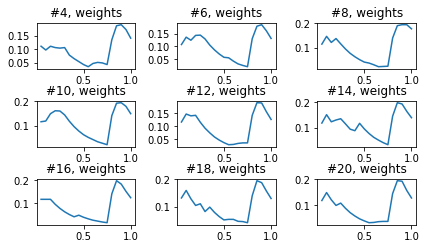

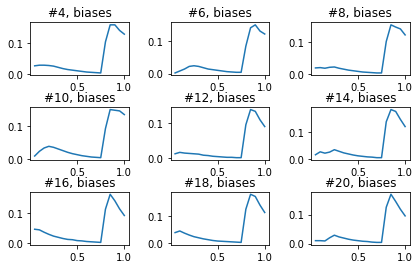

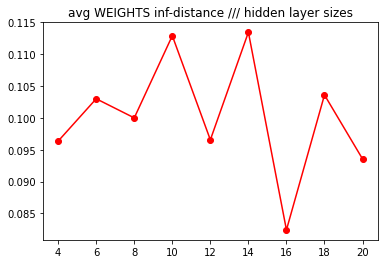

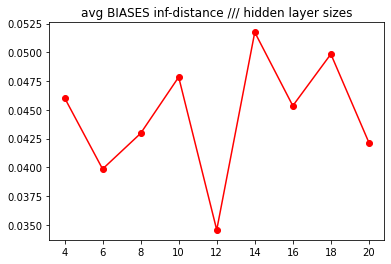

In [18]:
# inf-distance for weights and biases of classifiers with hidden size [ 4  6  8 10 12 14 16 18 20]
# training gap is 0.05

train_gap = 0.05
h_hidden_size = np.arange(4, 21, 2)
lr = 0.02
batch_size = 32
max_iter = 7000
avg_w_dists_wrt_sizes, avg_b_dists_wrt_sizes = plot_incremental_training_weight_bias_changes(train_gap, h_hidden_size,
                                                                                             lr, batch_size, max_iter,
                                                                                             Xo_train, yo_train, Xn, yn,
                                                                                             False)

In [19]:
print(avg_w_dists_wrt_sizes)

[0.09635000000000002, 0.10300000000000001, 0.10000000000000002, 0.1129, 0.09655, 0.11345000000000001, 0.0824, 0.1036, 0.09355]


inf-distance for weights and biases of classifiers with hidden size [ 4  6  8 10 12 14 16 18 20], training gap is 0.02, 
WEIGHTS or BIASES inf-distance /// % of D2 used


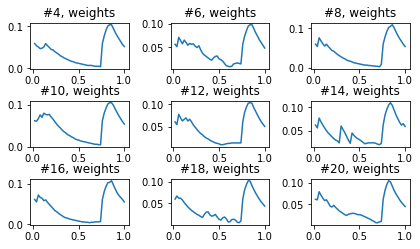

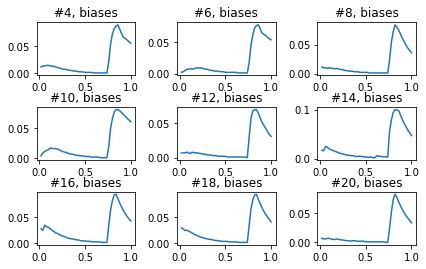

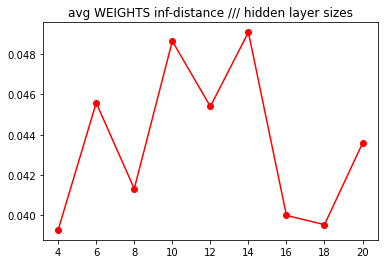

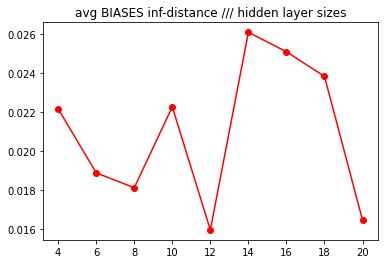

inf-distance for weights and biases of classifiers with hidden size [ 4  6  8 10 12 14 16 18 20], training gap is 0.05, 
WEIGHTS or BIASES inf-distance /// % of D2 used


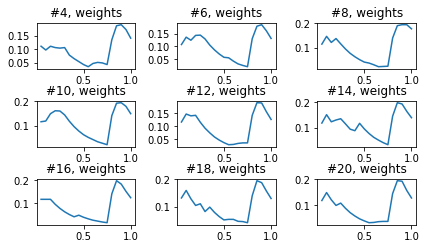

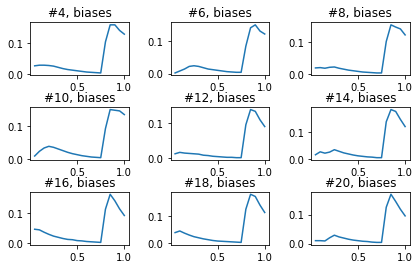

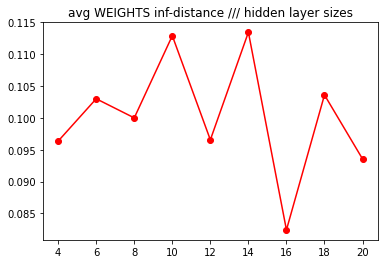

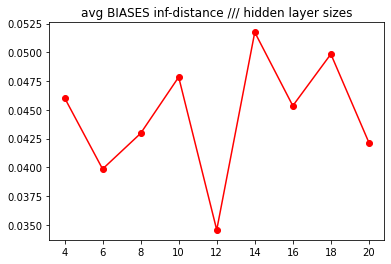

inf-distance for weights and biases of classifiers with hidden size [ 4  6  8 10 12 14 16 18 20], training gap is 0.1, 
WEIGHTS or BIASES inf-distance /// % of D2 used


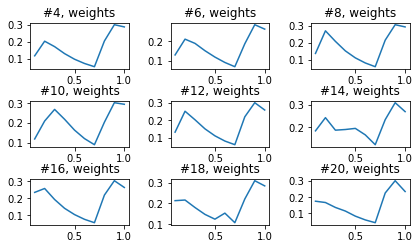

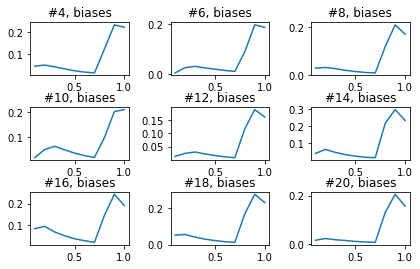

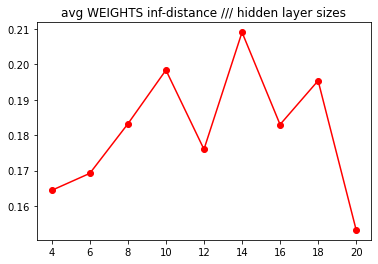

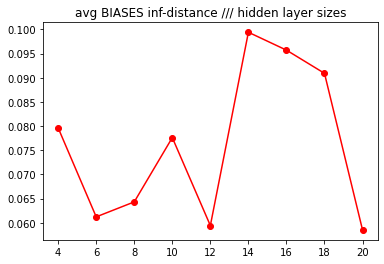

inf-distance for weights and biases of classifiers with hidden size [ 4  6  8 10 12 14 16 18 20], training gap is 0.2, 
WEIGHTS or BIASES inf-distance /// % of D2 used


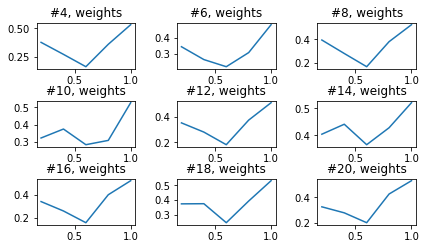

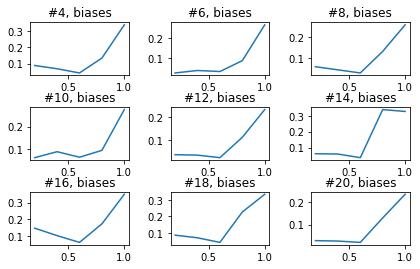

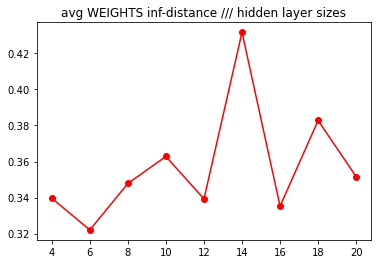

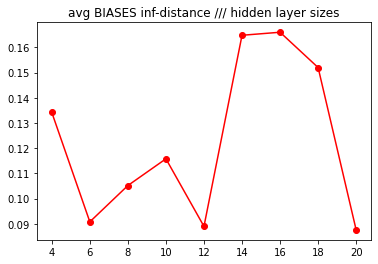

inf-distance for weights and biases of classifiers with hidden size [ 4  6  8 10 12 14 16 18 20], training gap is 0.25, 
WEIGHTS or BIASES inf-distance /// % of D2 used


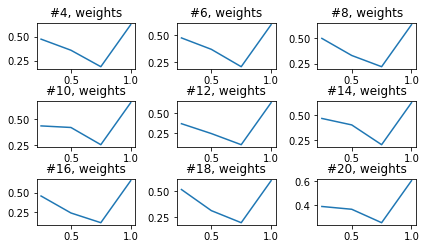

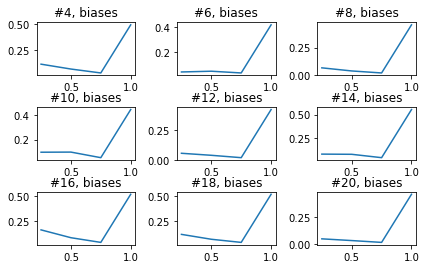

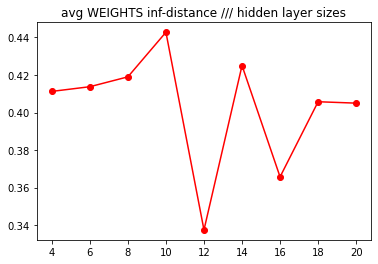

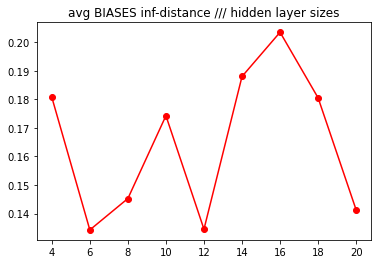

In [20]:
# inf-distance for weights and biases of classifiers with hidden size [ 4  6  8 10 12 14 16 18 20]
# training gap is [0.02, 0.05, 0.10, 0.20]

train_gaps = [0.02, 0.05, 0.10, 0.20, 0.25]
h_hidden_size = np.arange(4, 21, 2)
lr = 0.02
batch_size = 32
max_iter = 7000

avg_w_dists_wrt_gaps = []
avg_b_dists_wrt_gaps = []
for gap in train_gaps:
    thisw, thisb = plot_incremental_training_weight_bias_changes(gap, h_hidden_size,
                                                                 lr, batch_size, max_iter,
                                                                 Xo_train, yo_train, Xn, yn)
    avg_w_dists_wrt_gaps.append(thisw)
    avg_b_dists_wrt_gaps.append(thisb)

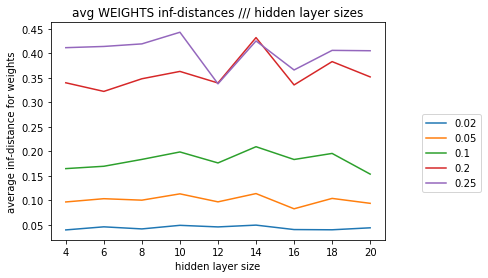

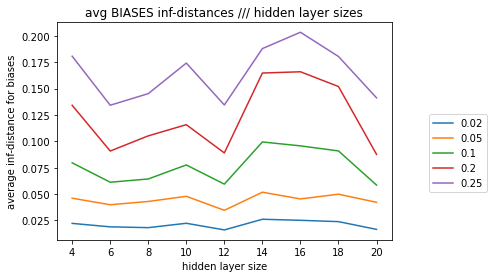

In [21]:
plt.figure(5)
plt.xlabel("hidden layer size")
plt.ylabel("average inf-distance for weights")
for i, item in enumerate(avg_w_dists_wrt_gaps):
    plt.plot(h_hidden_size, item, label=f"{train_gaps[i]}")
plt.legend(bbox_to_anchor=(1.3, 0.6))
plt.title('avg WEIGHTS inf-distances /// hidden layer sizes')

plt.figure(6)
plt.xlabel("hidden layer size")
plt.ylabel("average inf-distance for biases")
for i, item in enumerate(avg_b_dists_wrt_gaps):
    plt.plot(h_hidden_size, item, label=f"{train_gaps[i]}")
plt.legend(bbox_to_anchor=(1.3, 0.6))
plt.title('avg BIASES inf-distances /// hidden layer sizes')
plt.show()

# Experiments: computing counterfactuals

#### Procedures

These procedures are covered by UtilExp class

1. Train M on D1
2. Get delta-min, build M+ and M-: incrementally train M 5 times, using different 10% of D2 each time, then get the maximum inf-distance between the incremented models and M. Construct M+ and M- using delta-min
3. Get M2: incrementally train M on D2
4. Select test instances: randomly select 50 D1 instances to explain, clf(x)=0, desired class=1
5. Report metrics using each baseline

#### Metrics
- Proximity: normalised L1: "Scaling Guarantees for Nearest CEs" page 7
- Sparsity: L0
- Validity-delta: percentage of test instances that 1) have counterfactuals valid on m1, 2) counterfactuals valid on M+ and M- under delta_min
- Validity-m2: percentage of test instances that 1) have counterfactual(s), 2) these counterfactual(s) are all valid on both m1 and m2
- LOF: average LOF score

In [13]:
from joblib import dump, load

clf = load("credit.joblib")

In [14]:
util_exp = UtilExp(clf, Xo, yo, Xn, yn, columns, ordinal_features, discrete_features, continuous_features, preprocessor_old.feature_var_map, gap=0.1)
print(util_exp.delta_max)
print(util_exp.delta_min)

1.2818449987973342
0.20985369492417322


In [16]:
# OURS-ROBUST
ours_robust_ces = util_exp.run_ours_robust()
util_exp.evaluate_ces(ours_robust_ces)

50it [01:26,  1.72s/it]


total computation time in s: 86.23500275611877
found: 1.0
average normalised L1: 0.11639200482870883
average normalised L0: 0.33399999999999996
average lof score: 1.0
counterfactual validity: 1.0
delta validity: 1.0
m2 validity: 1.0


In [17]:
# OURS-NON-ROBUST
ours_non_robust_ces = util_exp.run_ours_non_robust()
util_exp.evaluate_ces(ours_non_robust_ces)

50it [00:01, 39.81it/s]


total computation time in s: 1.2579948902130127
found: 1.0
average normalised L1: 0.01594445840854775
average normalised L0: 0.08299999999999999
average lof score: 1.0
counterfactual validity: 1.0
delta validity: 0.0
m2 validity: 0.52


In [15]:
# ROAR
roar_ces = util_exp.run_ROAR(labels=(0,))
util_exp.evaluate_ces(roar_ces)

50it [00:01, 25.23it/s]
50it [00:02, 20.50it/s]
50it [00:02, 17.22it/s]
50it [00:03, 13.88it/s]
50it [00:03, 13.47it/s]
50it [00:04, 11.56it/s]
50it [00:05,  9.04it/s]
50it [00:05,  8.77it/s]
50it [00:05,  8.74it/s]
50it [00:05,  8.40it/s]
50it [00:18,  2.70it/s]

total computation time in s: 18.485605001449585
Set parameter Username
Academic license - for non-commercial use only - expires 2023-06-14


found: 1.0
average normalised L1: 0.05263371566395042
average normalised L0: 0.8868421052631575
average lof score: 1.0
counterfactual validity: 0.76
delta validity: 0.0
m2 validity: 0.76


In [17]:
# ROAR-robustness-boosted
roar_ces = util_exp.run_ROAR(labels=(0,), robust=True)
util_exp.evaluate_ces(roar_ces)

50it [00:01, 25.17it/s]
50it [00:02, 20.44it/s]
50it [00:02, 17.42it/s]
50it [00:03, 14.06it/s]
50it [00:03, 13.64it/s]
50it [00:04, 11.75it/s]
50it [00:05,  9.24it/s]
50it [00:05,  8.96it/s]
50it [00:05,  8.78it/s]
50it [00:05,  8.38it/s]
50it [03:26,  4.14s/it]


total computation time in s: 206.82859563827515
found: 1.0
average normalised L1: 0.04991925714604879
average normalised L0: 0.9048780487804877
average lof score: 1.0
counterfactual validity: 0.82
delta validity: 0.0
m2 validity: 0.78


In [19]:
# PROTOTYPES
proto_ces = util_exp.run_proto()
util_exp.evaluate_ces(proto_ces)

No encoder specified. Using k-d trees to represent class prototypes.
0it [00:00, ?it/s]No counterfactual found!
1it [00:40, 40.37s/it]No counterfactual found!
2it [01:20, 40.20s/it]No counterfactual found!
4it [02:37, 39.15s/it]No counterfactual found!
6it [03:57, 39.47s/it]No counterfactual found!
8it [05:16, 39.33s/it]No counterfactual found!
9it [05:58, 40.05s/it]No counterfactual found!
11it [07:17, 39.59s/it]No counterfactual found!
12it [07:56, 39.48s/it]No counterfactual found!
13it [08:35, 39.50s/it]No counterfactual found!
15it [09:55, 39.59s/it]No counterfactual found!
16it [10:34, 39.29s/it]No counterfactual found!
20it [13:02, 37.31s/it]No counterfactual found!
21it [13:41, 37.70s/it]No counterfactual found!
22it [14:20, 38.26s/it]No counterfactual found!
25it [16:21, 39.52s/it]No counterfactual found!
26it [17:02, 40.05s/it]No counterfactual found!
29it [19:03, 39.93s/it]No counterfactual found!
30it [19:44, 40.13s/it]No counterfactual found!
31it [20:24, 40.08s/it]No coun

total computation time in s: 1982.095556974411
found: 0.46
average normalised L1: 0.28638604722433814
average normalised L0: 0.7478260869565219
average lof score: -1.0
counterfactual validity: 0.46
delta validity: 0.0
m2 validity: 0.34


In [19]:

num_layers = get_clf_num_layers(clf)
delta = 0
nodes = build_inn_nodes(clf, num_layers)
weights, biases = build_inn_weights_biases(clf, num_layers, delta, nodes)
inn_delta_0 = Inn(num_layers, delta, nodes, weights, biases)

delta = 0.03
nodes = build_inn_nodes(clf, num_layers)
weights, biases = build_inn_weights_biases(clf, num_layers, delta, nodes)
inn_delta_non_0 = Inn(num_layers, delta, nodes, weights, biases)

dataset = Dataset(len(columns) - 1, clf.n_features_in_,
                       build_dataset_feature_types(columns, ordinal_features, discrete_features,
                                                   continuous_features), preprocessor_old.feature_var_map)
x = util_exp.test_instances[0]
y_prime = 1
# start the iteration
eps = 0.9
# find CE first:
this_solver = OptSolver(dataset, inn_delta_0, y_prime, x, mode=0, eps=eps, M=10000, x_prime=None)
this_cf = this_solver.compute_counterfactual()
this_solver = OptSolver(dataset, inn_delta_non_0, y_prime, x, mode=1, M=10000, x_prime=this_cf)
found, bound = this_solver.compute_inn_bounds()
print(found, bound)


1 0.3083491583853912
